In [55]:
import pandas as pd 
import numpy as np 
from numpy.fft import fft
import matplotlib.pyplot as plt
import fastparquet
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew
from scipy.stats import linregress
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import find_peaks
from scipy.stats import entropy
import joblib

from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier


from xgboost import plot_importance, XGBClassifier
from tqdm import tqdm
from sklearn.svm import SVC

**Загрузим данные**

In [2]:
feachures_scaled = pd.read_csv('data/feachures_scaled.csv')
target = pd.read_csv('data/target.csv')

**Разделим на тренировочную и тестовую выборку**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(feachures_scaled, target['label'], test_size=0.3, random_state=42, stratify=target)

**Обучим RandomForest**

До этого были проведены эксперименты по выбору лучшей модели и гиперпараметров для каждой из пробуемых моделей. Были обучены градиентные бустинги `LightGBM` и `XGBoost`, `логистическая легрессия`, `SVC` алгоритм и `random forest`. Метрикой для оценки качества алгоритма была выбрана AUC ROC.

По результатам экспериментов самое высокое значение метрики получилось при использовании алгоритма `RandomForestClassifier` со следующими гиперпараметрами:

    bootstrap = True - каждое дерево строится на бутстрапированных выборках из данных
    class_weight= 'balanced' - случайный лес обучается с поправками на возможный дисбаланс классов, придавая веса меньшему классу
    n_estimators = 500 - в лесе 500 деревьев, ответы которых будут усредняться
    max_depth = 50 - максимальная глубина отдельного дерева не привышает 50
    max_features = 'sqrt' - каждый раз дерево строится на случайной подвыборке из признакового пространства (RSM). Берется корень из числа признаков
    min_samples_leaf = 15 - минимальное число элементов для создания отдельного листа
    min_samples_split = 25 - минимальное число элементов в ноде дерева, чтобы сделать сплит по этой ноде

При таких гиперпараметрах достигается значение метрики AUC ROC около 0.8

In [53]:
%%time

rf_model = RandomForestClassifier(random_state=2, bootstrap= True, 
                                  class_weight= 'balanced', n_estimators = 500, max_depth = 50, 
                                  max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 25 )


rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
roc_auc_score(y_test, y_pred_rf)


CPU times: user 1min 52s, sys: 9.99 ms, total: 1min 52s
Wall time: 1min 52s


0.7962992366947139

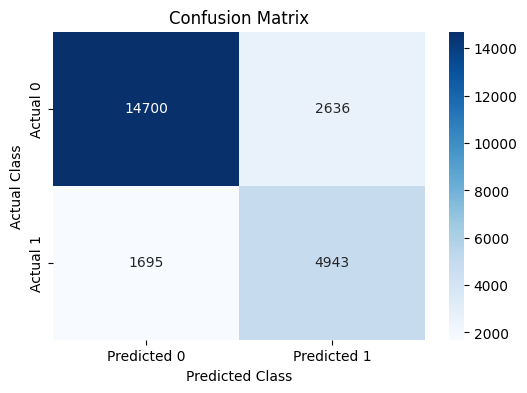

In [54]:
cm = confusion_matrix(y_test, y_pred_rf)

cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

**Запишем обученную модель в файл `random_forest_model.joblib`**

In [56]:
joblib.dump(rf_model, 'data/random_forest_model.joblib')

['random_forest_model.joblib']